# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings
import pyproj
warnings.filterwarnings('ignore')

%matplotlib inline

# Instatiate a grid from a DEM raster

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [2]:
grid = Grid.from_raster('../data/n30w100_con', data_name='dem')

# Resolve flats in DEM

In [3]:
grid.resolve_flats('dem', out_name='inflated_dem')

# Specify flow direction values

In [4]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Read a flow direction grid from a raster

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [5]:
grid.read_raster('../data/n30w100_dir', data_name='dir')

# Delineate catchment

In [6]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [7]:
# Clip the bounding box to the catchment
grid.clip_to('catch', pad=(1,1,1,1))

In [8]:
# Get a view of the catchment
catch = grid.view('catch', nodata=np.nan)

In [9]:
# Compute flowdir from unprojected DEM
grid.flowdir('inflated_dem', out_name='ndir', dirmap=dirmap,
             apply_mask=False)

In [10]:
# Compute flowdir from projected DEM
new_crs = pyproj.Proj('+init=epsg:3083')
grid.flowdir('inflated_dem', out_name='pdir', dirmap=dirmap,
             as_crs=new_crs, apply_mask=False)

# Get flow accumulation

In [11]:
# Accumulation from flow directions directly from HydroSHEDS
grid.accumulation(data='dir', dirmap=dirmap, out_name='acc_ref')
# Accumulation from unprojected flow directions
grid.accumulation(data='ndir', dirmap=dirmap, out_name='acc_noproj')
# Accumulation from projected flow directions
grid.accumulation(data='pdir', dirmap=dirmap, out_name='acc_proj')

# Compare accumulations

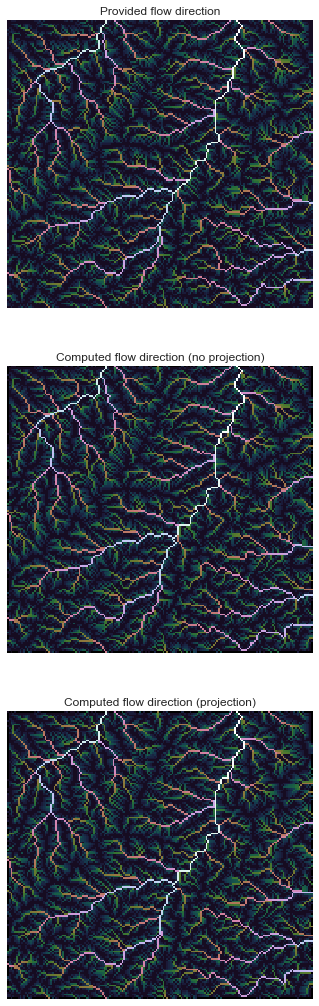

In [12]:
fig, ax = plt.subplots(3, figsize=(6,18))
im = ax[0].imshow(grid.acc_ref + 1, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc_ref.max()))
im = ax[1].imshow(grid.acc_noproj + 1, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc_noproj.max()))
im = ax[2].imshow(grid.acc_proj + 1, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc_proj.max()))
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])
ax[0].set_title('Provided flow direction')
ax[1].set_title('Computed flow direction (no projection)')
ax[2].set_title('Computed flow direction (projection)')

In [13]:
print('Max accumulation (reference):\t\t', grid.acc_ref.max())
print('Max accumulation (no projection):\t', grid.acc_noproj.max())
print('Max accumulation (projection):\t\t', grid.acc_proj.max())

Max accumulation (reference):		 11447
Max accumulation (no projection):	 11426
Max accumulation (projection):		 11448
